In [1]:
import sys
import os
from utils import *

/home/ljaffeux/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-06-03 15:15:52.827982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748956552.936738  122803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748956552.975972  122803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 15:15:53.245356: I tensorflow/core/platform/cpu_f

In [4]:
timesteps = 120 # Length of sequence
resampling ='5s' # Time spacing
data_root='../Data'
features = ['AOA_RAD', 'AOS_RAD','PITCH','ROLL','GROUND_SPEED','VERTICAL_SPEED','TAS'] # Key features you want to learn may add ['AOA_RAD', 'AOS_RAD','PITCH','ROLL','TAS']
# ,'VERTICAL_WIND','NORTHWARD_WIND','EASTWARD_WIND'
# Define campàaign to learn from
campaigns = ['LIAISE'] # Can use more than one campaign for gathering training data set
INSs = ['IMU1']
# Version for archiving
version = 'LIAISE_bias'
# Additional informations you might want to add to the configfile (will be read once you load the data)
observations = '' 

# Loads and formats the data, add random biases in radome angles, scale it, and split into <span style="color:red">training</span>, <span style="color:blue">validation</span> and <span style="color:green">testing</span> sets (<span style="color:red">64%</span>, <span style="color:blue">20%</span>, <span style="color:green">16%</span>)


In [9]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()

def create_sequences_with_biases(data, timesteps):
    data = data.copy()  # Avoid modifying the original DataFrame
    sequences = []
    bias_seq = []
    
    for i in range(len(data) - timesteps):
        aoa_bias = 2 * random.random() - 1
        aos_bias = 2 * random.random() - 1
        sequence = data.iloc[i : i + timesteps].copy()
        sequence['AOA_RAD'] += np.radians(aoa_bias)
        sequence['AOS_RAD'] += np.radians(aos_bias)
        sequences.append(sequence.values)  # Store as NumPy array
        bias_seq.append([aoa_bias, aos_bias])  # Store biases
    
    return np.array(sequences), np.array(bias_seq)
    
train_data = []
target_data = []
version_dir = f'Bias_regression/{version}'
config_path = os.path.join(version_dir, "config.txt")

if os.path.exists(version_dir) and os.path.exists(os.path.join(version_dir, 'X_data.npy')):
    print(f"✅ Found saved data in {version_dir}. Loading...")
    X_data = np.load(os.path.join(version_dir, 'X_data.npy'))
    Y_data = np.load(os.path.join(version_dir, 'Y_data.npy'))
    scaler = joblib.load(os.path.join(version_dir, 'scaler_train.pkl'))
    scalery = joblib.load(os.path.join(version_dir, 'scaler_target.pkl'))
    X_scaled = scaler.transform(X_data.reshape(-1, X_data.shape[-1])).reshape(X_data.shape)
    Y_scaled = scalery.transform(Y_data.reshape(-1, Y_data.shape[-1])).reshape(Y_data.shape)    
    print(f"✅ {version} loaded and scaled")
    # Read and display config
    if os.path.exists(config_path):
        print(f"📄 Configuration loaded from {config_path}:")
        with open(config_path, "r") as f:
            for line in f:
                print("   ", line.strip())
else:
    print(f"❌ No saved data in {version_dir}.")
    print("🔄 Processing data from scratch...")
    # Save model configuration variables
    os.makedirs(f'{version_dir}')
    with open(config_path, "w") as f:
        f.write(f"timesteps = {timesteps}\n")
        f.write(f"resampling = '{resampling}'\n")
        f.write(f"data = '{campaigns}'\n")
        f.write(f"INS = '{INSs}'\n")
        f.write(f"features = {features}\n")
        f.write(f"version = {version}\n")
        f.write(f"observations = {observations}\n")

    for campaign,INS in zip(campaigns,INSs) :
        if not campaign == 'MAESTRO':
            INS=''
        segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
        raw_data_dir = f'{data_root}/Raw'
        if not os.path.exists(segmentation_dir):
            print(f"Segmentation directory not found: {segmentation_dir}")
        
        for fname in tqdm(os.listdir(segmentation_dir)):
            if not fname.endswith('.yaml'):
                continue
        
            flight_number = extract_flight_number(fname)
            if flight_number is None:
                continue
            if flight_number < 200009 and campaign == 'EUREC4A': # Special condition for EUREC4A
                print(f'Skipping bad EUREC4A flight {flight_number}')
                continue
        
            try:
                yaml_path = os.path.join(segmentation_dir, fname)
        
                # Match raw data folder
                matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                                       if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
                if not matching_raw_folder:
                    print(f"❌ No raw folder found for {campaign} {INS}")
                    continue
        
                raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
                # Look for any .nc file containing the flight number
                flight_str = f'{flight_number:02d}'
                nc_candidates = [f for f in os.listdir(raw_folder)
                                 if f.endswith('.nc') and flight_str in f]
                
                if not nc_candidates:
                    print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
                    continue
                
                nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
                # print(f"  - Loading NetCDF: {nc_candidates[0]}")
        
                yaml_data = read_yaml(yaml_path)
                df_raw = load_raw_data(nc_path)
                if 'GROUND_SPEED' in features:
                    df_raw['GROUND_SPEED'] = np.sqrt(df_raw['NORTH_SPEED']**2 + df_raw['EAST_SPEED']**2)
                if 'SIDESLIP_RAD' in df_raw.columns:
                    df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
                if (campaign,INS)==('MAESTRO','IMU2'):
                    df_raw['AOS_RAD'] = df_raw['AOS_RAD'] - np.radians(0.545)
                seq, bias_seq = create_sequences_with_biases(df_raw[features].resample(resampling).mean().dropna(), timesteps)
                train_data.extend(seq)
                target_data.extend(bias_seq)
            except Exception as e:
                print(f"❌ Error in flight {flight_number}: {e}")
        
    X_data = train_data
    Y_data = target_data
    # Scale the data
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scalery = MinMaxScaler(feature_range=(0, 1))
    data_reshaped = np.array(X_data).reshape(-1, np.array(X_data).shape[-1])  # Reshape for scaling
    X_scaled = scaler.fit_transform(data_reshaped).reshape(np.array(X_data).shape)
    
    Y_data = np.array(Y_data).reshape(-1, np.array(Y_data).shape[-1])  # Reshape for scaling
    Y_scaled = scalery.fit_transform(Y_data).reshape(np.array(Y_data).shape)
    # save data for next time
    np.save(f"{version_dir}/X_data.npy", X_data)
    np.save(f"{version_dir}/Y_data.npy", Y_data)
    # Scale the data

    # Save scaler for future usage
    joblib.dump(scaler, f"{version_dir}/scaler_train.pkl")
    joblib.dump(scalery, f"{version_dir}/scaler_target.pkl")
    print(f"✅ {version} saved and scaled")
    
    
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
# Define the LSTM Autoencoder model
n_features = 2  # Number of features

❌ No saved data in Bias_regression/LIAISE_bias.
🔄 Processing data from scratch...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:45<00:00,  5.73s/it]


✅ LIAISE_bias saved and scaled


AttributeError: 'list' object has no attribute 'shape'

In [14]:
n_features = 2 # aoa and aos biases
# Define input shape
input_shape = (timesteps, n_features)
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # LSTM layer with tunable units
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        activation='relu',
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Fully connected layers for output prediction
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_features))  # Output layer with 2 values (AoA and AoS bias)

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='mse',
        metrics=['mae']
    )

    return model

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Reduce LR by a factor of 0.5
    patience=3,           # Wait for 3 epochs before reducing LR
    min_lr=1e-6,          # Minimum learning rate
    verbose=1
)
# Initialize Keras Tuner's RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of different hyperparameter configurations to try
    executions_per_trial=1,
    directory=f'Bias_regression/tuner_results_{version}',
    project_name='LSTM_CNN'
)

# Search for the best hyperparameters
tuner.search(X_train,
             Y_train,
             callbacks=[lr_scheduler],
             epochs=10,
             batch_size=16,
             validation_data=(X_val, Y_val))

# Get the best model and hyperparameters
best_model_reg = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# Print the best hyperparameters
print("Best Hyperparameters: ", best_hyperparameters)

# Train the best model
history = best_model_reg.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=16,
    callbacks=[lr_scheduler],
    validation_data=(X_val, Y_val),
    verbose=1
)

# Evaluate the best model
loss, mae = best_model_reg.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Trial 5 Complete [00h 02m 05s]
val_loss: 0.034224145114421844

Best val_loss So Far: 0.004025386646389961
Total elapsed time: 00h 27m 53s
Best Hyperparameters:  {'lstm_units': 128, 'dropout_3': 0.1, 'learning_rate': 0.0006705744640297546}
Epoch 1/20


/home/ljaffeux/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - loss: 0.0056 - mae: 0.0572 - val_loss: 0.0059 - val_mae: 0.0585 - learning_rate: 6.7057e-04
Epoch 2/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 20.6242 - mae: 0.1300 - val_loss: 0.0663 - val_mae: 0.2203 - learning_rate: 6.7057e-04
Epoch 3/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0338 - mae: 0.1421 - val_loss: 0.0066 - val_mae: 0.0631 - learning_rate: 6.7057e-04
Epoch 4/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0080 - mae: 0.0695 - val_loss: 0.0052 - val_mae: 0.0547 - learning_rate: 6.7057e-04
Epoch 5/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0065 - mae: 0.0623 - val_loss: 0.0048 - val_mae: 0.0522 - learning_rate: 6.7057e-04
Epoch 6/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0057 - mae: 0.0581 - val_loss: 0.0046 - val_mae: 0.0515 - learning_rate: 6.7057e-04
Epoch 7/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0054 - mae: 0.0561 - val_loss: 0.0045 - val_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (16, 128)              │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 32)               │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,480 (865.16 KB)

 Trainable params: 73,826 (288.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,654 (576.78 KB)

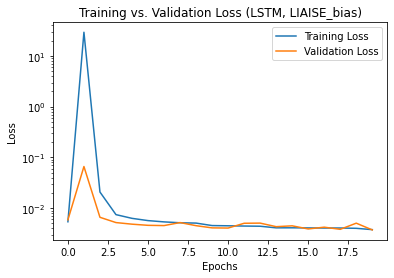

In [16]:
# Display summary of the best model
best_model_reg.summary()
best_model_reg.save(f'{version_dir}/LSTM_CNN.keras')

# Loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.title(f'Training vs. Validation Loss (LSTM, {version})')
plt.savefig(f'{version_dir}/Training_LSTM_CNN.png')
plt.show()

192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Mean Absolute Errors for each of the 2 biases:
aoa_bias: 0.05
aos_bias: 0.13


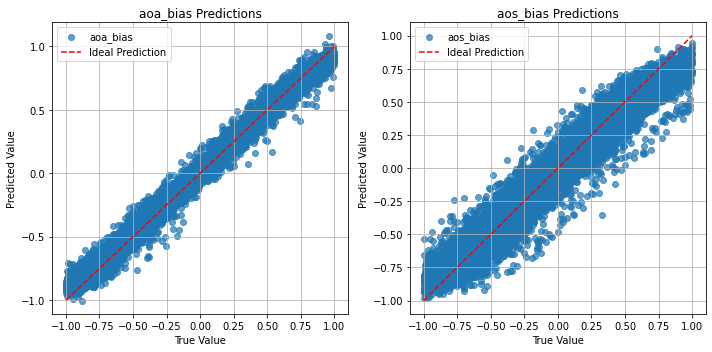

In [18]:
Y_pred = best_model_reg.predict(X_test)

# Inverse transform the values
Y_true_inv = (scalery.inverse_transform(Y_test))
Y_pred_inv = (scalery.inverse_transform(Y_pred))

# Define parameter names
dic_par = { 0 : 'aoa_bias',1 : 'aos_bias'}

# Calculate absolute error
absolute_errors = np.abs(Y_true_inv - Y_pred_inv)
mean_absolute_errors = np.mean(absolute_errors, axis=0)

# Print mean absolute error for each parameter
print("Mean Absolute Errors for each of the 2 biases:")
for i in range(2):
    print(f"{dic_par[i]}: {mean_absolute_errors[i]:.2f}")

# Plot predictions vs. true values
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.scatter(Y_true_inv[:, i], Y_pred_inv[:, i], alpha=0.7, label=dic_par[i])
    plt.plot([min(Y_true_inv[:, i]), max(Y_true_inv[:, i])], 
             [min(Y_true_inv[:, i]), max(Y_true_inv[:, i])], 
             'r--', label="Ideal Prediction")
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    plt.title(f"{dic_par[i]} Predictions")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()